<a href="https://colab.research.google.com/github/MatiasSiles/Sales-Optimization/blob/main/model_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Dict, List, Tuple, Any, Optional, Union
from datetime import datetime, timedelta
import joblib
import json

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV,
    StratifiedKFold, KFold, TimeSeriesSplit
)

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,
    OneHotEncoder, PolynomialFeatures
)

from sklearn.feature_selection import (
    SelectKBest, f_regression, f_classif, mutual_info_regression,
    mutual_info_classif, RFE, RFECV
)
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor,
    GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier,
    ExtraTreesRegressor, ExtraTreesClassifier
)
from sklearn.linear_model import (
    LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, HuberRegressor
)
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, FactorAnalysis, TruncatedSVD
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, silhouette_score
)

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import (
        Dense, Dropout, BatchNormalization, Input, LSTM, GRU,
        Conv1D, MaxPooling1D, Flatten, Embedding
    )
    from tensorflow.keras.optimizers import Adam, RMSprop, SGD
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l1, l2, l1_l2
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available")

# Advanced ML Libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

# Statistical Libraries
from scipy import stats
from scipy.stats import (
    pearsonr, spearmanr, chi2_contingency, ttest_ind, mannwhitneyu,
    kruskal, shapiro, jarque_bera, anderson
)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from utils2 import *
warnings.filterwarnings('ignore')

In [53]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

np.random.seed(42)

# EDA for training models

In [54]:
# Data upload
df = pd.read_csv('/content/Sales_Business_Testing.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [55]:
# Basic info of the dataset
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB") # converts actual memory usage from bytes to megabytes
print("\nFirst 5 rows:")
print(df.head())

print("\nData types:")
print(df.dtypes.value_counts())

print("\nMissing values:")
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

Dataset shape: (10000, 91)
Memory usage: 6.94 MB

First 5 rows:
   customer_age  unit_price  quantity  discount_rate  profit_margin  subtotal  \
0            56      350.94         8           0.18           0.49   2807.52   
1            69      472.66         2           0.26           0.45    945.32   
2            46      497.80         2           0.12           0.14    995.60   
3            32      230.64         3           0.08           0.27    691.91   
4            60      133.74         3           0.15           0.47    401.22   

   discount_amount  tax_rate  tax_amount  shipping_cost  ...  \
0           500.26       0.1      280.75          36.33  ...   
1           247.76       0.1       94.53          46.80  ...   
2           122.48       0.1       99.56          22.75  ...   
3            55.90       0.1       69.19          11.17  ...   
4            59.19       0.1       40.12           9.59  ...   

   region_target_encoded  sales_rep_target_encoded  \
0         

       customer_age  unit_price  quantity  discount_rate  profit_margin  \
count       10000.0    10000.00  10000.00       10000.00       10000.00   
mean           48.8      255.25      4.99           0.15           0.30   
std            17.9      141.27      2.57           0.09           0.12   
min            18.0       10.06      1.00           0.00           0.10   
25%            34.0      135.06      3.00           0.08           0.20   
50%            49.0      256.20      5.00           0.15           0.30   
75%            64.0      375.93      7.00           0.23           0.40   
max            79.0      499.95      9.00           0.30           0.50   

       subtotal  discount_amount  tax_rate  tax_amount  shipping_cost  ...  \
count  10000.00         10000.00   10000.0    10000.00       10000.00  ...   
mean    1274.94           192.29       0.1      127.49          27.58  ...   
std     1028.76           209.57       0.0      102.88          12.92  ...   
min       10

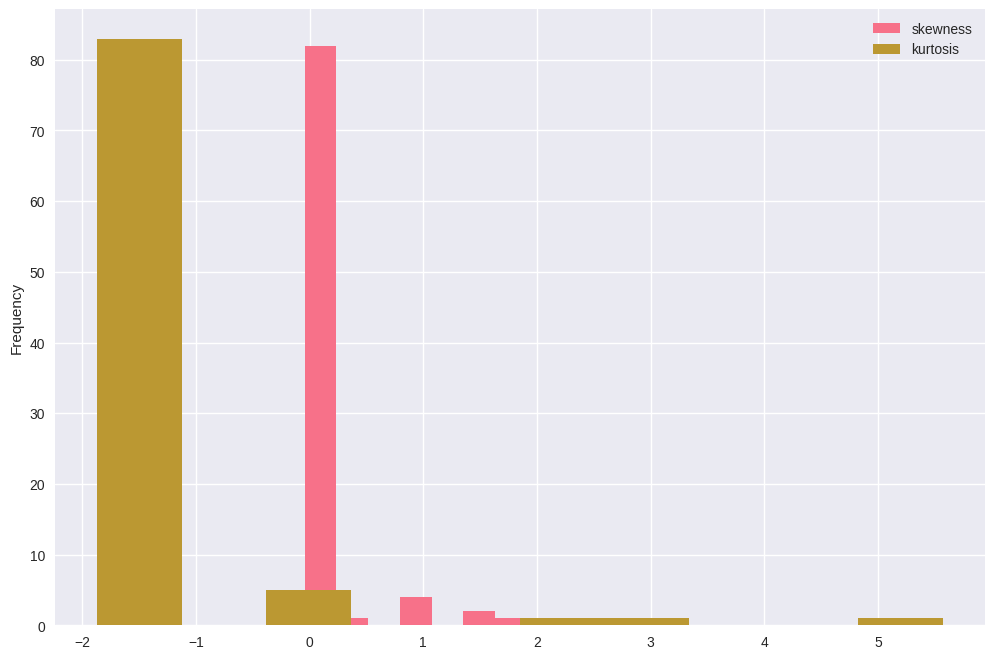

In [56]:
# Data analysis
analyzer = StatisticalAnalyzer()
descriptive_stats = analyzer.descriptive_statistics(df)

print(descriptive_stats['numeric_summary'].round(2))

# CATEGORICAL VARIABLES SUMMARY, in this case, there isn't categorical variables, because this testing datast don't have
# for col, stats in descriptive_stats['categorical_summary'].items():
#     print(f"\n{col}:")
#     print(f"  Unique values: {stats['unique_values']}")
#     print(f"  Mode: {stats['mode']}")
#     print("  Top 5 values:")
#     print(stats['value_counts'].head())

# Distribution analysis
print()
descriptive_stats['skewness'].plot(kind='hist', label='skewness')
descriptive_stats['kurtosis'].plot(kind='hist', label='kurtosis')
plt.legend()
plt.show()

Why i choose these targets?:

*   total_amount: The aim is to predict the business's sales taking into account the variables that influence them, such as quantity sold, discounts prices, dates, etc
*   profit: anticipate profits, to know which products are profitable, improve decision-making and optimize prices.
*   satisfaction_score: Reduce churn, recommend products to each type
ofcustomer, improve customer experience
*   is_returned: reduce returns, optimize inventory, improve quality and products
*   order_frequency: customer retention, detect loyal customers, personalize marketing, improve cash flow
*   customer_lifetime_days: Seeking to ensure that customers remain active in the business for longer periods of time


High correlations found (>0.7):
          Feature1         Feature2  Correlation
0         subtotal  discount_amount     0.739431
1         subtotal       tax_amount     1.000000
2         subtotal     total_amount     0.989647
3         subtotal           profit     0.843291
4  discount_amount       tax_amount     0.739431
5       tax_amount     total_amount     0.989647
6       tax_amount           profit     0.843291
7     total_amount           profit     0.851825


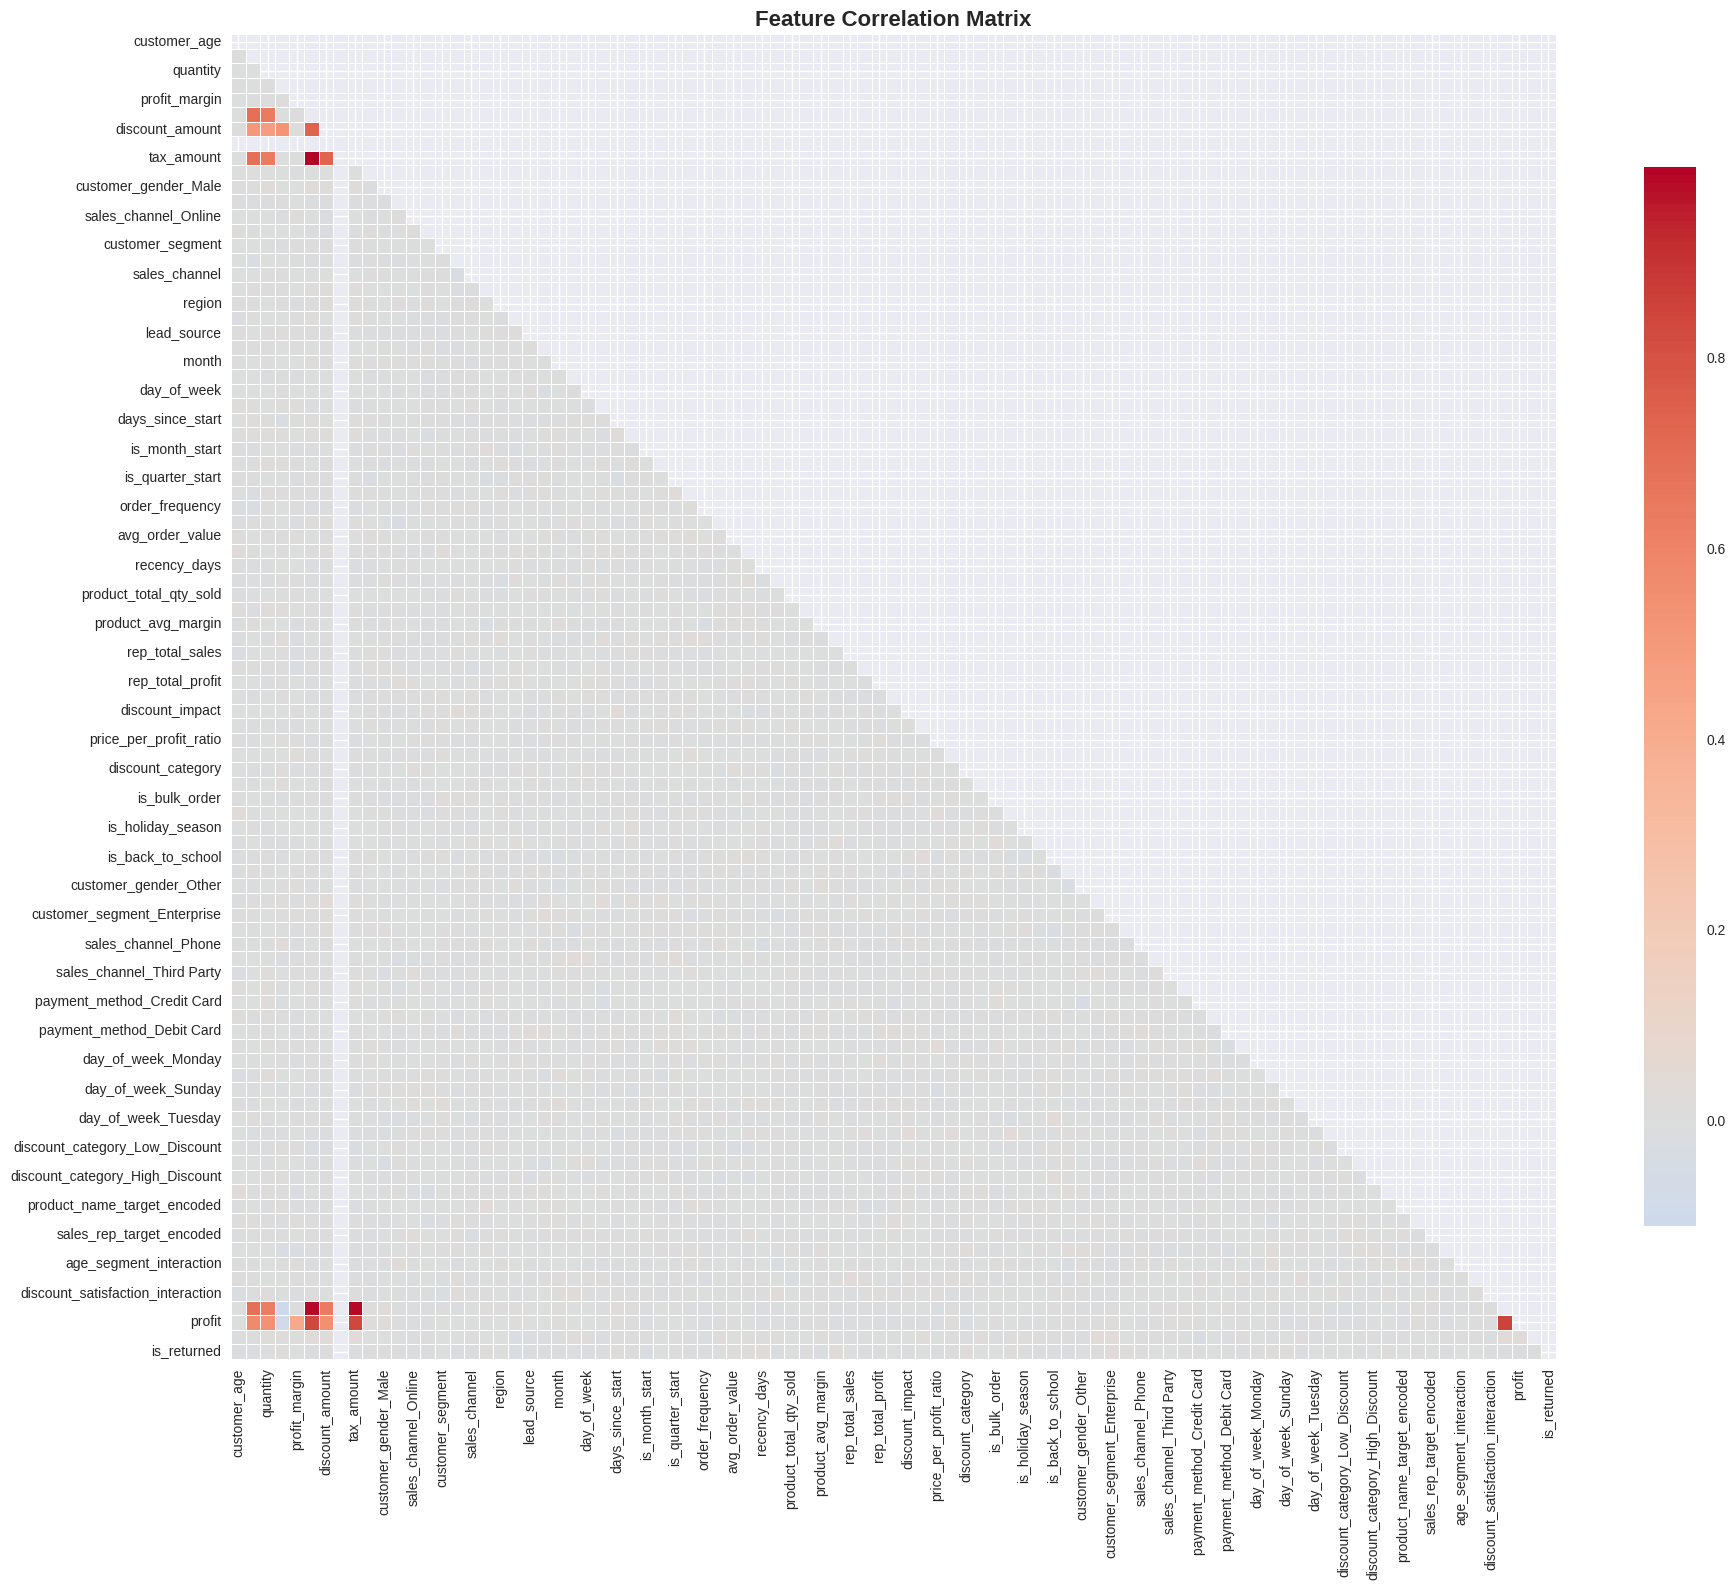


total_amount - Top 10 correlations:
total_amount                      1.000000
subtotal                          0.989647
tax_amount                        0.989647
profit                            0.851825
unit_price                        0.679854
discount_amount                   0.635556
quantity                          0.630042
discount_rate                     0.110911
discount_category_Low_Discount    0.024250
satisfaction_score                0.023979
Name: total_amount, dtype: float64

profit - Top 10 correlations:
profit                1.000000
total_amount          0.851825
tax_amount            0.843291
subtotal              0.843291
unit_price            0.577967
discount_amount       0.543101
quantity              0.535175
profit_margin         0.417419
discount_rate         0.090147
satisfaction_score    0.025564
Name: profit, dtype: float64

satisfaction_score - Top 10 correlations:
satisfaction_score             1.000000
customer_segment_Enterprise    0.029295
payme

In [57]:
corr_matrix = analyzer.correlation_analysis(df, method='pearson')

# Find highly correlated features, this algorithm goes through the entire dataset by rows, comparing it with the threshold
def find_high_correlations(corr_matrix, threshold=0.8):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)): # 91 columns
        for j in range(i+1, len(corr_matrix.columns)): # It is a loop where each iteration goes through all the columns while subtracting 1 column until reaching 0 columns
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'Feature1': corr_matrix.columns[i], # add column 1 which participates in high correlations
                    'Feature2': corr_matrix.columns[j], # add column 2 which participates in high correlations
                    'Correlation': corr_matrix.iloc[i, j] # add the value
                })
    return pd.DataFrame(high_corr_pairs)

high_corr = find_high_correlations(corr_matrix, threshold=0.7)

if not high_corr.empty: # check whether or not high correlations were found
    print(f"\nHigh correlations found (>0.7):")
    print(high_corr)
else:
    print("\nNo high correlations found (>0.7)")

# Visualize correlation matrix, It's a confusing graph but I modified it to only show the correlations.
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # only shows half of the heat map
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Target variable correlations
TARGET_VARIABLES = ['total_amount', 'profit', 'satisfaction_score','is_returned', 'order_frequency', 'customer_lifetime_days']

for target in TARGET_VARIABLES:
    if target in df.columns:
        target_corr = corr_matrix[target].abs().sort_values(ascending=False) # find the 10 best correlations for each target
        print(f"\n{target} - Top 10 correlations:")
        print(target_corr.head(10))

i decided to do this because i think that can exist hidden relationships in important features for the training mode. If exist that relationship, probably can improve the model's performance. Whether a difference or relationship in the data is real or just a matter of luck

Significance:
*   p < 0.05 → is significant: probably is real the relationship
*   p > 0.05 → is not significant

In [58]:
# It looks for relationships between numerical and categorical variables
categorical_cols = ['customer_gender', 'customer_segment', 'sales_channel', 'payment_method']
numerical_targets = ['total_amount', 'profit', 'satisfaction_score']

hypothesis_results = {}

for cat_col in categorical_cols:
    if cat_col in df.columns:
        for num_col in numerical_targets:
            if num_col in df.columns:
                print(f"\nTesting {cat_col} vs {num_col}:")

                test_result = analyzer.hypothesis_testing(
                    df, cat_col, num_col, test_type='auto'
                )

                hypothesis_results[f"{cat_col}_vs_{num_col}"] = test_result

                print(f"  Test used: {test_result['test_used']}")
                print(f"  P-value: {test_result['p_value']:.6f}")
                print(f"  Significant: {'Yes' if test_result['significant'] else 'No'}")


Testing customer_gender vs total_amount:
  Test used: Kruskal-Wallis
  P-value: 0.495825
  Significant: No

Testing customer_gender vs profit:
  Test used: Kruskal-Wallis
  P-value: 0.537488
  Significant: No

Testing customer_gender vs satisfaction_score:
  Test used: Kruskal-Wallis
  P-value: 0.541328
  Significant: No

Testing customer_segment vs total_amount:
  Test used: Kruskal-Wallis
  P-value: 0.448128
  Significant: No

Testing customer_segment vs profit:
  Test used: Kruskal-Wallis
  P-value: 0.444930
  Significant: No

Testing customer_segment vs satisfaction_score:
  Test used: Kruskal-Wallis
  P-value: 0.488615
  Significant: No

Testing sales_channel vs total_amount:
  Test used: Kruskal-Wallis
  P-value: 0.628394
  Significant: No

Testing sales_channel vs profit:
  Test used: Kruskal-Wallis
  P-value: 0.604640
  Significant: No

Testing sales_channel vs satisfaction_score:
  Test used: Kruskal-Wallis
  P-value: 0.531426
  Significant: No

Testing payment_method vs tota

time series analysis

Analyzing sales over time...
Time series statistics:
  Mean: $206287.89
  Std: $19117.66
  Autocorrelation (lag=1): -0.010


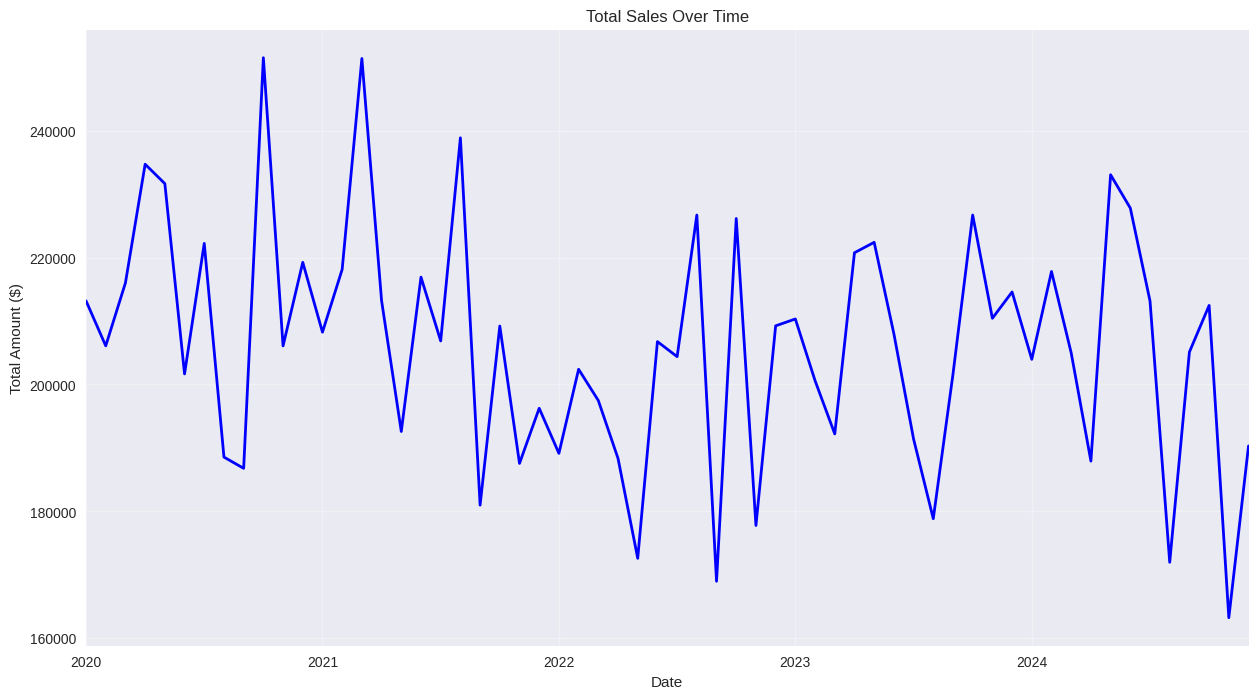

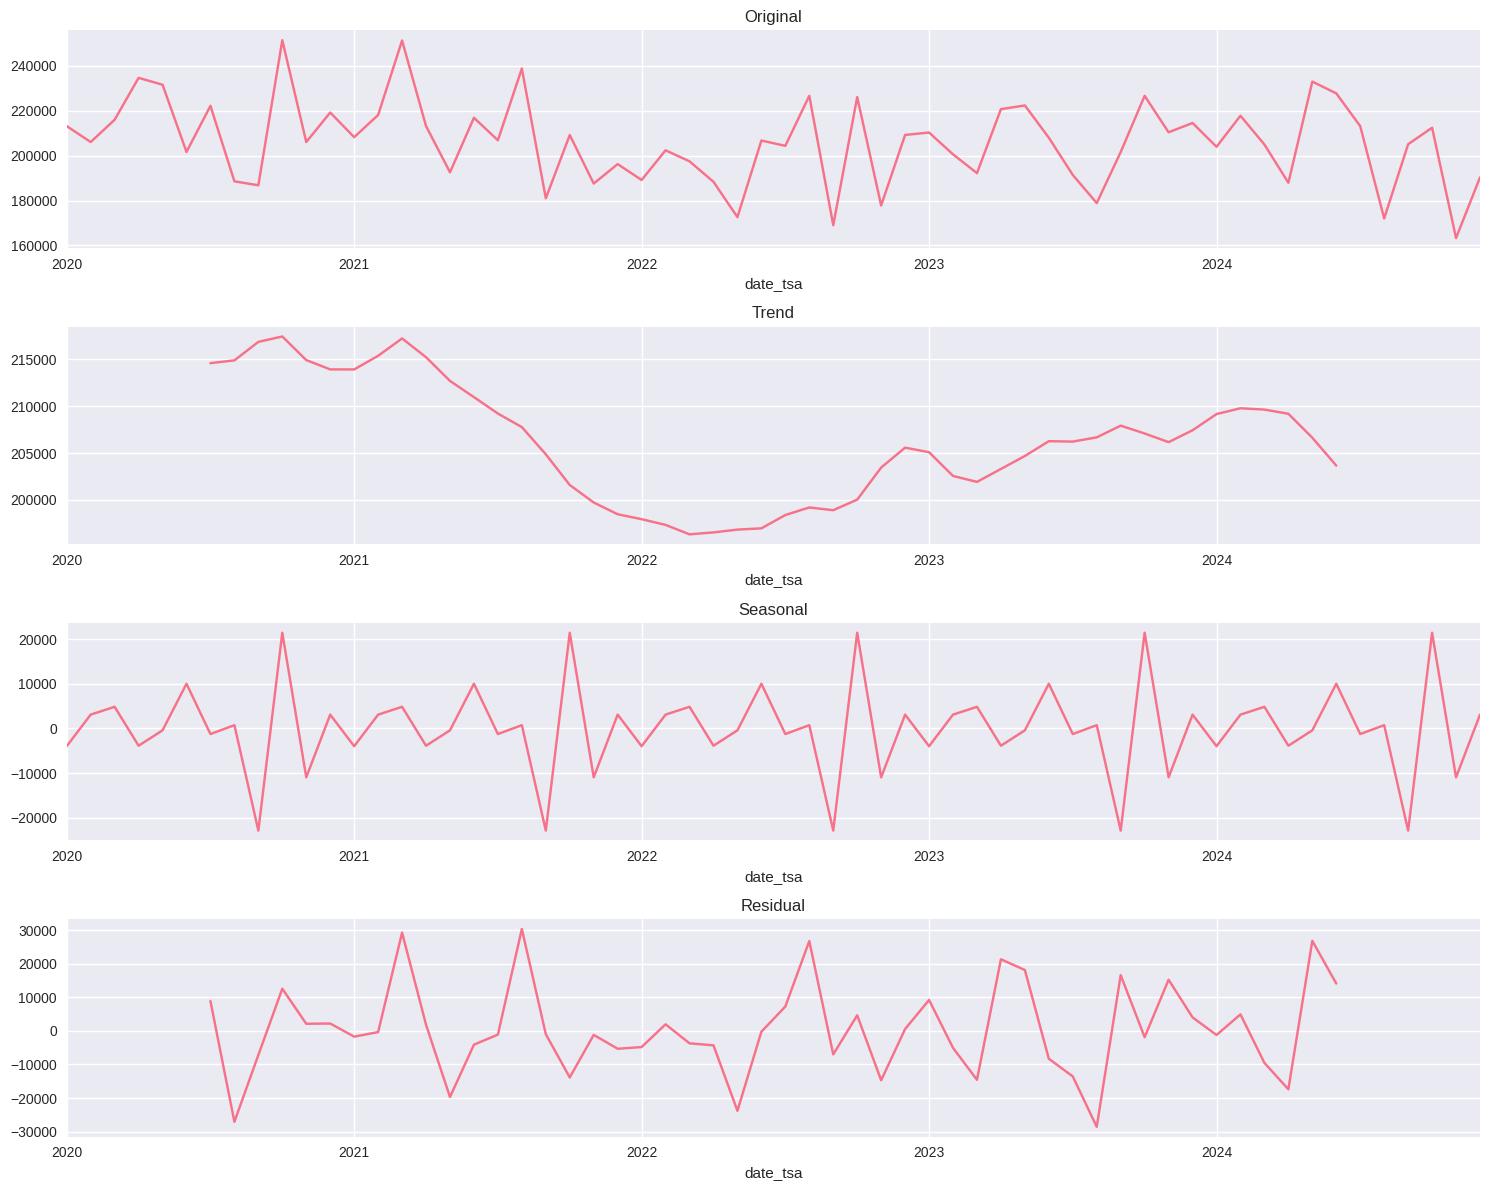

In [59]:
df['year'] = np.random.randint(2020, 2025, size=10000)
df['month'] = np.random.randint(1, 13, size=10000)

# Create a date column for time series analysis
if 'year' in df.columns and 'month' in df.columns:
    df['date_tsa'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

    # Perform time series analysis on total_amount
    if 'total_amount' in df.columns:
        print("Analyzing sales over time...")

        ts_results = analyzer.time_series_analysis(
            df, 'date_tsa', 'total_amount', freq='M'
        )

        print(f"Time series statistics:")
        print(f"  Mean: ${ts_results['mean']:.2f}")
        print(f"  Std: ${ts_results['std']:.2f}")
        if ts_results['autocorrelation']:
            print(f"  Autocorrelation (lag=1): {ts_results['autocorrelation']:.3f}")

        # Plot time series
        plt.figure(figsize=(15, 8))
        ts_results['original_series'].plot(title='Total Sales Over Time',
                                         color='blue', linewidth=2)
        plt.xlabel('Date')
        plt.ylabel('Total Amount ($)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot decomposition if available
        if 'decomposition' in ts_results:
            fig, axes = plt.subplots(4, 1, figsize=(15, 12))
            ts_results['original_series'].plot(ax=axes[0], title='Original')
            ts_results['trend'].plot(ax=axes[1], title='Trend')
            ts_results['seasonal'].plot(ax=axes[2], title='Seasonal')
            ts_results['residual'].plot(ax=axes[3], title='Residual')
            plt.tight_layout()
            plt.show()

#Customer Segmentation Kmeans

In [68]:
# Initialize the segmenter
segmenter = CustomerSegmenter()

# Prepare data for segmentation
segmentation_features = ['total_spent', 'avg_order_value', 'order_frequency',
                        'customer_lifetime_days', 'satisfaction_score']

# Check which features are available
available_features = [f for f in segmentation_features if f in df.columns]
available_features

['total_spent',
 'avg_order_value',
 'order_frequency',
 'customer_lifetime_days',
 'satisfaction_score']

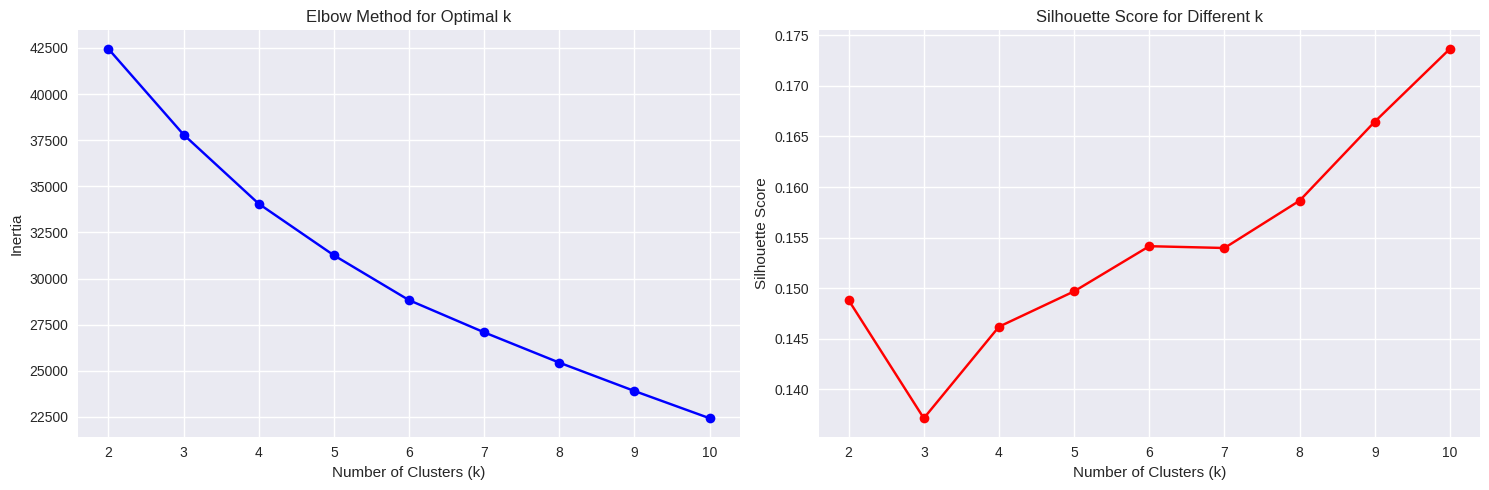


Optimal number of clusters: 10
Best silhouette score: 0.174


In [71]:
# Find Optimal Number of Clusters

if len(available_features) >= 3:
    # Find optimal clusters
    clustering_data = df[available_features].fillna(0)
    optimal_clusters = segmenter.find_optimal_clusters(clustering_data, max_clusters=10)

    # Plot elbow curve and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Elbow curve
    ax1.plot(optimal_clusters['k_values'], optimal_clusters['inertias'], 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.grid(True)

    # Silhouette scores
    ax2.plot(optimal_clusters['k_values'], optimal_clusters['silhouette_scores'], 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score for Different k')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Find best k based on silhouette score
    best_k_idx = np.argmax(optimal_clusters['silhouette_scores'])
    best_k = optimal_clusters['k_values'][best_k_idx]
    best_silhouette = optimal_clusters['silhouette_scores'][best_k_idx]

    print(f"\nOptimal number of clusters: {best_k}")
    print(f"Best silhouette score: {best_silhouette:.3f}")
else:
    print("Not enough features for clustering analysis")

🎯 PERFORMING RFM ANALYSIS
🔄 Performing RFM Analysis...
✅ RFM Segmentation completed!
📊 Segment distribution:
segments
Potential Loyalists    2747
About to Sleep         1917
Lost                   1697
Loyal Customers         952
Promising               932
Champions               652
New Customers           613
Hibernating             490
Name: count, dtype: int64


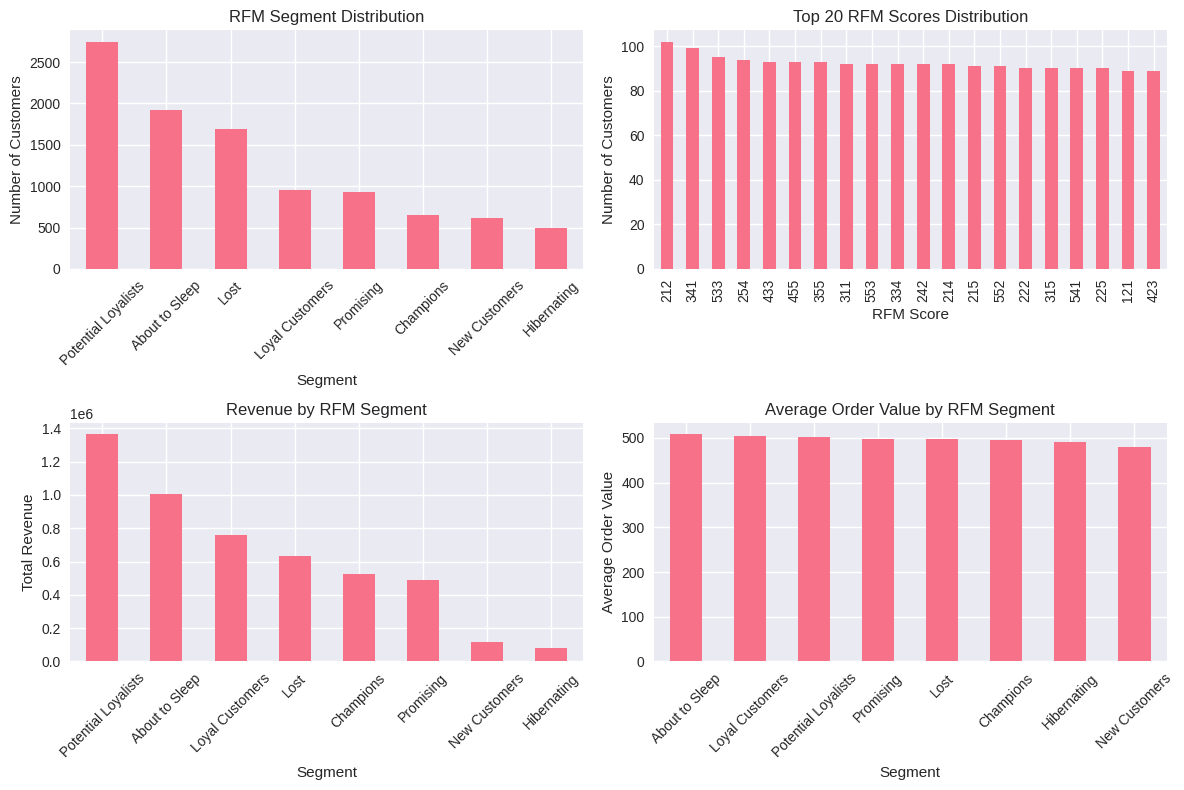

In [62]:
print("🎯 PERFORMING RFM ANALYSIS")
print("=" * 50)

# Ensure required columns exist
if 'recency_days' not in df.columns:
    df['recency_days'] = np.random.randint(1, 365, len(df))
if 'total_spent' not in df.columns:
    df['total_spent'] = df['total_amount'] * np.random.uniform(1, 5, len(df))
if 'order_frequency' not in df.columns:
    df['order_frequency'] = np.random.randint(1, 20, len(df))

# Perform RFM analysis
print("🔄 Performing RFM Analysis...")
rfm_segments = segmenter.rfm_segmentation(df)

print("✅ RFM Segmentation completed!")
print(f"📊 Segment distribution:")
segment_counts = rfm_segments['segments'].value_counts()
print(segment_counts)

# Add RFM results to dataframe
df['rfm_segment'] = rfm_segments['segments']
df['rfm_score'] = rfm_segments['rfm_combined']

# Visualize RFM segments
plt.figure(figsize=(12, 8))

# RFM Segment distribution
plt.subplot(2, 2, 1)
segment_counts.plot(kind='bar')
plt.title('RFM Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# RFM scores distribution
plt.subplot(2, 2, 2)
df['rfm_score'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 RFM Scores Distribution')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')

# Revenue by segment
plt.subplot(2, 2, 3)
revenue_by_segment = df.groupby('rfm_segment')['total_spent'].sum().sort_values(ascending=False)
revenue_by_segment.plot(kind='bar')
plt.title('Revenue by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)

# Average order value by segment
plt.subplot(2, 2, 4)
avg_order_by_segment = df.groupby('rfm_segment')['avg_order_value'].mean().sort_values(ascending=False)
avg_order_by_segment.plot(kind='bar')
plt.title('Average Order Value by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [63]:
print("🔄 PERFORMING K-MEANS CLUSTERING")
print("=" * 50)

if len(available_features) >= 3:
    # Perform K-means clustering
    print("🔄 Performing K-means clustering...")

    clustering_data = df[available_features].fillna(0)
    kmeans_result = segmenter.kmeans_segmentation(clustering_data, n_clusters=5)

    print("✅ K-means clustering completed!")
    print(f"📊 Cluster distribution:")
    cluster_counts = pd.Series(kmeans_result['labels']).value_counts().sort_index()
    print(cluster_counts)

    print(f"📈 Silhouette Score: {kmeans_result['silhouette_score']:.3f}")
    print(f"📉 Inertia: {kmeans_result['inertia']:.2f}")

    # Add cluster labels to dataframe
    df['cluster'] = kmeans_result['labels']

    # Display cluster centers
    print("\n🎯 Cluster Centers:")
    centers_df = pd.DataFrame(kmeans_result['centers'], columns=available_features)
    centers_df.index = [f'Cluster {i}' for i in range(len(centers_df))]
    print(centers_df.round(2))

else:
    print("❌ Not enough features for K-means clustering")

🔄 PERFORMING K-MEANS CLUSTERING
🔄 Performing K-means clustering...
✅ K-means clustering completed!
📊 Cluster distribution:
0    1941
1    2024
2    2074
3    2026
4    1935
Name: count, dtype: int64
📈 Silhouette Score: 0.150
📉 Inertia: 31260.59

🎯 Cluster Centers:
           total_spent  avg_order_value  order_frequency  \
Cluster 0       729.43           680.97           239.63   
Cluster 1       702.17           285.62           671.08   
Cluster 2       330.73           264.53           343.28   
Cluster 3       221.71           610.22           513.53   
Cluster 4       518.83           677.47           752.91   

           customer_lifetime_days  satisfaction_score  
Cluster 0                  178.27                3.25  
Cluster 1                  114.15                2.80  
Cluster 2                  259.30                2.86  
Cluster 3                   91.03                2.93  
Cluster 4                  272.15                3.20  


📊 VISUALIZING CLUSTERING RESULTS


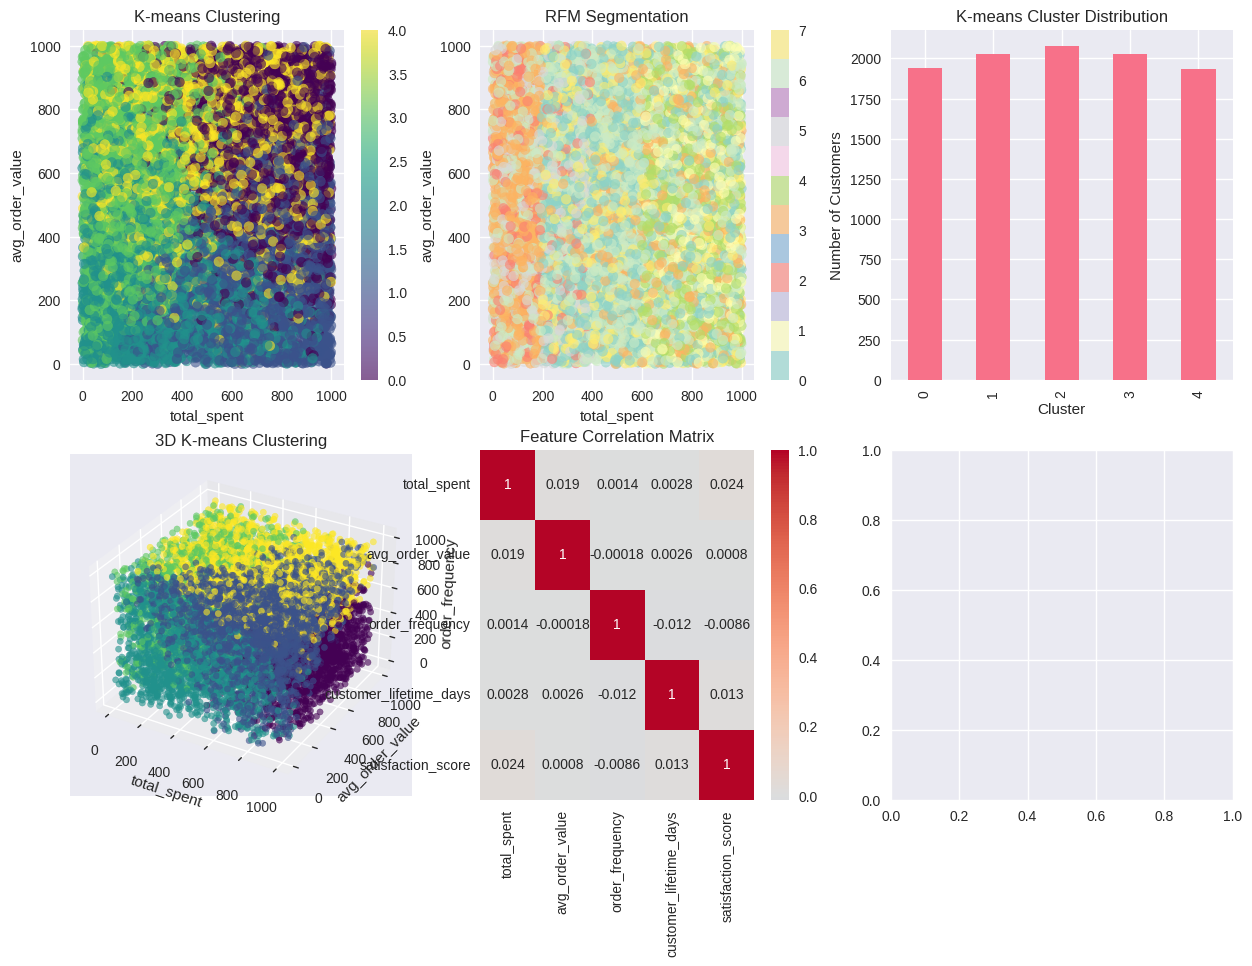

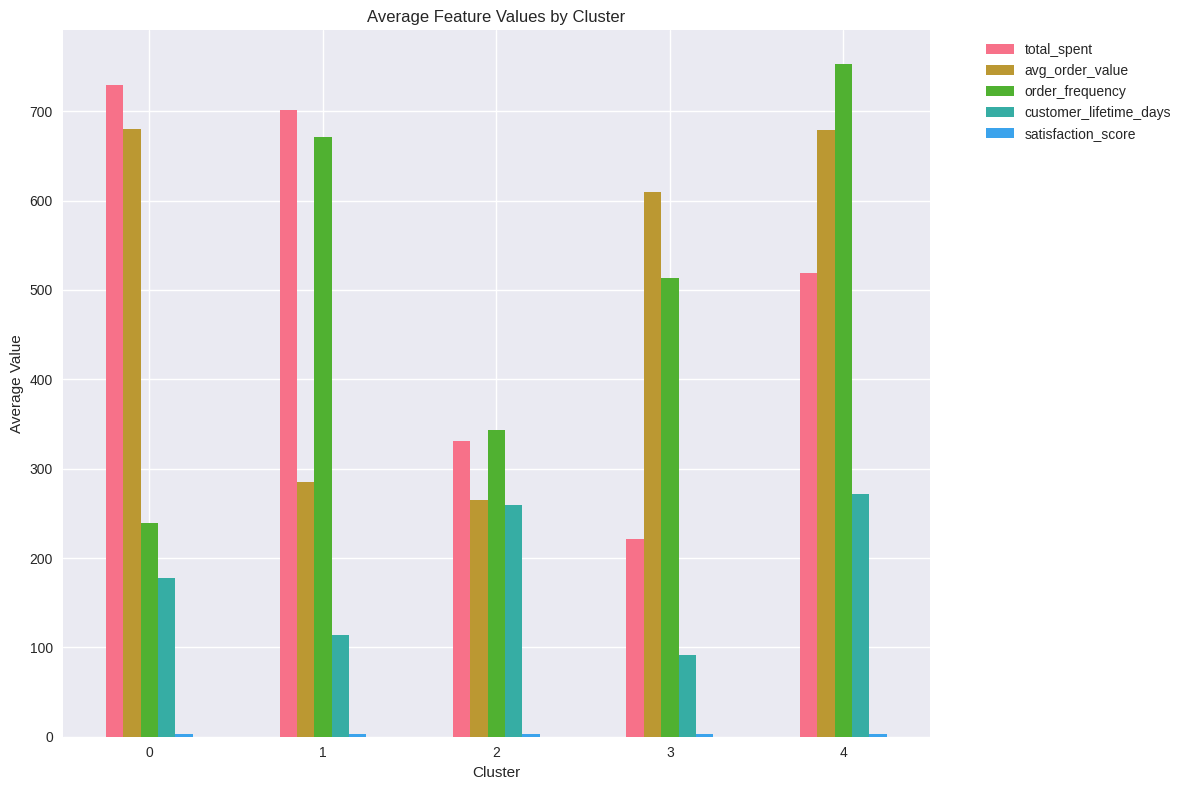

In [64]:
# CELL 9: Visualize Clustering Results
print("📊 VISUALIZING CLUSTERING RESULTS")
print("=" * 50)

if len(available_features) >= 2 and 'cluster' in df.columns:
    # Visualize clusters
    plt.figure(figsize=(15, 10))

    # K-means clustering visualization
    plt.subplot(2, 3, 1)
    scatter = plt.scatter(df[available_features[0]], df[available_features[1]],
                         c=df['cluster'], cmap='viridis', alpha=0.6)
    plt.xlabel(available_features[0])
    plt.ylabel(available_features[1])
    plt.title('K-means Clustering')
    plt.colorbar(scatter)

    # RFM segmentation visualization
    plt.subplot(2, 3, 2)
    rfm_numeric = pd.Categorical(df['rfm_segment']).codes
    scatter2 = plt.scatter(df[available_features[0]], df[available_features[1]],
                          c=rfm_numeric, cmap='Set3', alpha=0.6)
    plt.xlabel(available_features[0])
    plt.ylabel(available_features[1])
    plt.title('RFM Segmentation')
    plt.colorbar(scatter2)

    # Cluster distribution
    plt.subplot(2, 3, 3)
    cluster_counts.plot(kind='bar')
    plt.title('K-means Cluster Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')

    # 3D visualization if we have 3+ features
    if len(available_features) >= 3:
        ax = plt.subplot(2, 3, 4, projection='3d')
        scatter3d = ax.scatter(df[available_features[0]], df[available_features[1]],
                              df[available_features[2]], c=df['cluster'], cmap='viridis', alpha=0.6)
        ax.set_xlabel(available_features[0])
        ax.set_ylabel(available_features[1])
        ax.set_zlabel(available_features[2])
        ax.set_title('3D K-means Clustering')

    # Feature correlation heatmap
    plt.subplot(2, 3, 5)
    correlation_matrix = df[available_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')

    # Cluster characteristics
    plt.subplot(2, 3, 6)
    cluster_means = df.groupby('cluster')[available_features].mean()
    cluster_means.plot(kind='bar')
    plt.title('Average Feature Values by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Value')
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [66]:
# ============================================================================
# CELL 9: Machine Learning Model Training - Regression
# ============================================================================

print("🤖 MACHINE LEARNING MODEL TRAINING - REGRESSION")
print("="*50)

# Initialize ML optimizer
ml_optimizer = MachineLearningOptimizer()

# Train regression models for each numerical target
regression_targets = ['total_amount', 'profit', 'satisfaction_score', 'customer_lifetime_days']

regression_results = {}

for target in regression_targets:
    if target in df.columns:
        print(f"\n🎯 Training models for target: {target}")
        print("-" * 40)

        # Prepare data
        X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
            df, target, test_size=0.2, random_state=42
        )

        print(f"📊 Train set shape: {X_train.shape}")
        print(f"📊 Test set shape: {X_test.shape}")

        # Train regression models
        results = ml_optimizer.train_regression_models(X_train, y_train, X_test, y_test)
        regression_results[target] = results

        # Display results
        print(f"\n📈 Model Performance for {target}:")
        for model_name, metrics in results.items():
            if 'error' not in metrics:
                print(f"  {model_name}:")
                print(f"    Test R²: {metrics['test_r2']:.4f}")
                print(f"    Test MSE: {metrics['test_mse']:.4f}")

        # Find best model
        best_model = max(results.items(),
                        key=lambda x: x[1].get('test_r2', -np.inf) if 'error' not in x[1] else -np.inf)
        print(f"\n🏆 Best model for {target}: {best_model[0]} (R² = {best_model[1]['test_r2']:.4f})")

# ============================================================================
# CELL 10: Machine Learning Model Training - Classification
# ============================================================================

print("🤖 MACHINE LEARNING MODEL TRAINING - CLASSIFICATION")
print("="*50)

# Train classification models for binary targets
classification_targets = ['is_returned']

classification_results = {}

for target in classification_targets:
    if target in df.columns:
        print(f"\n🎯 Training models for target: {target}")
        print("-" * 40)

        # Prepare data
        X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
            df, target, test_size=0.2, random_state=42
        )

        print(f"📊 Train set shape: {X_train.shape}")
        print(f"📊 Test set shape: {X_test.shape}")
        print(f"📊 Class distribution: {pd.Series(y_train).value_counts().to_dict()}")

        # Train classification models
        results = ml_optimizer.train_classification_models(X_train, y_train, X_test, y_test)
        classification_results[target] = results

        # Display results
        print(f"\n📈 Model Performance for {target}:")
        for model_name, metrics in results.items():
            if 'error' not in metrics:
                print(f"  {model_name}:")
                print(f"    Test Accuracy: {metrics['test_accuracy']:.4f}")
                print(f"    F1 Score: {metrics['f1_score']:.4f}")
                if 'roc_auc' in metrics:
                    print(f"    ROC AUC: {metrics['roc_auc']:.4f}")

        # Find best model
        best_model = max(results.items(),
                        key=lambda x: x[1].get('test_accuracy', -np.inf) if 'error' not in x[1] else -np.inf)
        print(f"\n🏆 Best model for {target}: {best_model[0]} (Accuracy = {best_model[1]['test_accuracy']:.4f})")

# ============================================================================
# CELL 11: Hyperparameter Optimization
# ============================================================================

print("⚙️ HYPERPARAMETER OPTIMIZATION")
print("="*50)

# Perform hyperparameter optimization for best performing models
optimization_results = {}

# Optimize for one regression target
if 'total_amount' in df.columns:
    print("🔄 Optimizing Random Forest for total_amount prediction...")

    X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
        df, 'total_amount', test_size=0.2, random_state=42
    )

    opt_result = ml_optimizer.hyperparameter_optimization(
        X_train, y_train, model_type='random_forest', task='regression'
    )

    optimization_results['total_amount_rf'] = opt_result

    print("✅ Optimization completed!")
    print(f"🏆 Best parameters: {opt_result['best_params']}")
    print(f"📊 Best score: {opt_result['best_score']:.4f}")

# Optimize for classification target
if 'is_returned' in df.columns:
    print("\n🔄 Optimizing Random Forest for return prediction...")

    X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
        df, 'is_returned', test_size=0.2, random_state=42
    )

    opt_result = ml_optimizer.hyperparameter_optimization(
        X_train, y_train, model_type='random_forest', task='classification'
    )

    optimization_results['is_returned_rf'] = opt_result

    print("✅ Optimization completed!")
    print(f"🏆 Best parameters: {opt_result['best_params']}")
    print(f"📊 Best score: {opt_result['best_score']:.4f}")

# ============================================================================
# CELL 12: Feature Importance Analysis
# ============================================================================

print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Analyze feature importance from trained models
if hasattr(ml_optimizer, 'feature_importance') and ml_optimizer.feature_importance:

    for model_name, importance_dict in ml_optimizer.feature_importance.items():
        print(f"\n🎯 Feature Importance - {model_name}:")
        print("-" * 40)

        # Sort features by importance
        sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

        # Display top 10 features
        print("Top 10 most important features:")
        for i, (feature, importance) in enumerate(sorted_features[:10], 1):
            print(f"  {i:2d}. {feature:<30} {importance:.4f}")

        # Plot feature importance
        if len(sorted_features) > 0:
            features, importances = zip(*sorted_features[:15])

            plt.figure(figsize=(10, 8))
            y_pos = np.arange(len(features))
            plt.barh(y_pos, importances)
            plt.yticks(y_pos, features)
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

# Perform additional feature selection
print("\n🔍 ADDITIONAL FEATURE SELECTION")
print("-" * 40)

if 'total_amount' in df.columns:
    X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
        df, 'total_amount', test_size=0.2, random_state=42
    )

    # Mutual information feature selection
    selected_features = ml_optimizer.feature_selection(
        X_train, y_train, method='mutual_info', k=20
    )

    print(f"✅ Selected {selected_features.shape[1]} features using mutual information")
    print(f"📊 Selected features: {list(selected_features.columns)}")

# ============================================================================
# CELL 13: Deep Learning Models (if TensorFlow available)
# ============================================================================

print("🧠 DEEP LEARNING MODELS")
print("="*50)

# Check if TensorFlow is available
try:
    import tensorflow as tf
    from utils import DeepLearningOptimizer

    print("✅ TensorFlow available - Training deep learning models...")

    # Initialize deep learning optimizer
    dl_optimizer = DeepLearningOptimizer()

    # Train neural network for regression
    if 'total_amount' in df.columns:
        print("\n🔄 Training neural network for total_amount prediction...")

        X_train, X_test, y_train, y_test = ml_optimizer.prepare_data(
            df, 'total_amount', test_size=0.2, random_state=42
        )

        # Scale features for neural network
        X_train_scaled, X_test_scaled = ml_optimizer.scale_features(
            X_train, X_test, method='standard'
        )

        # Train neural network
        nn_results = dl_optimizer.train_neural_network(
            X_train_scaled, y_train, X_test_scaled, y_test,
            task='regression', epochs=50, batch_size=32
        )

        print("✅ Neural network training completed!")
        print(f"📊 Final test MSE: {nn_results['test_mse']:.4f}")
        print(f"📊 Final test R²: {nn_results['test_r2']:.4f}")

        # Plot training history
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(nn_results['history']['loss'], label='Training Loss')
        plt.plot(nn_results['history']['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        if 'mae' in nn_results['history']:
            plt.plot(nn_results['history']['mae'], label='Training MAE')
            plt.plot(nn_results['history']['val_mae'], label='Validation MAE')
            plt.title('Model MAE')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()

        plt.tight_layout()
        plt.show()

except ImportError:
    print("❌ TensorFlow not available - Skipping deep learning models")
    print("💡 Install TensorFlow to enable deep learning features: pip install tensorflow")

# ============================================================================
# CELL 14: Sales Forecasting
# ============================================================================

print("📈 SALES FORECASTING")
print("="*50)

# Initialize sales forecaster
forecaster = SalesForecaster()

# Prepare time series data for forecasting
if 'date' in df.columns and 'total_amount' in df.columns:

    # Aggregate sales by date
    daily_sales = df.groupby('date')['total_amount'].sum().sort_index()

    print(f"📊 Time series data shape: {daily_sales.shape}")
    print(f"📊 Date range: {daily_sales.index.min()} to {daily_sales.index.max()}")

    # Simple moving average forecast
    print("\n🔄 Generating moving average forecast...")
    ma_forecast = forecaster.moving_average_forecast(daily_sales, window=3, periods=12)

    print("✅ Moving average forecast generated!")
    print(f"📊 Forecast for next 12 periods:")
    print(ma_forecast.round(2))

    # Exponential smoothing forecast
    print("\n🔄 Generating exponential smoothing forecast...")
    es_forecast = forecaster.exponential_smoothing_forecast(daily_sales, periods=12)

    print("✅ Exponential smoothing forecast generated!")
    print(f"📊 Forecast for next 12 periods:")
    print(es_forecast.round(2))

    # Plot forecasts
    plt.figure(figsize=(15, 8))

    # Plot historical data
    plt.plot(daily_sales.index, daily_sales.values, label='Historical Sales', color='blue')

    # Create future dates for plotting
    last_date = daily_sales.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

    # Plot forecasts
    plt.plot(future_dates, ma_forecast, label='Moving Average Forecast',
             color='red', linestyle='--', marker='o')
    plt.plot(future_dates, es_forecast, label='Exponential Smoothing Forecast',
             color='green', linestyle='--', marker='s')

    plt.title('

SyntaxError: unterminated string literal (detected at line 308) (ipython-input-66-709216076.py, line 308)